In [11]:
import h5py
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from pyrsimg import readTiff, imgShow,second_to_dyr,geo2imagexy
import pandas as pd
import re
from datetime import datetime,timedelta
from shapely.geometry import Point
import geopandas as gpd
from skimage.transform import resize
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import threading
from concurrent.futures import ThreadPoolExecutor


In [12]:
path_atl13 = r'E:\lakes\Qinghailake\readout\ATL13_20192023.h5'
path_rsimg = r'E:\lakes\Qinghailake\Qinghailake.tif'
path_vec=r"E:\lakes\Qinghailake\inward_buffered_lake_WGS84.gpkg"

In [13]:
!h5ls $path_atl13

beam_type                Dataset {730812}
h                        Dataset {730812}
lat                      Dataset {730812}
lon                      Dataset {730812}
orbit_type               Dataset {730812}
qf_bckgrd                Dataset {730812}
qf_bias_em               Dataset {730812}
qf_bias_fit              Dataset {730812}
rgt                      Dataset {730812}
spot                     Dataset {730812}
stdev_water_surf         Dataset {730812}
t_dyr                    Dataset {730812}


In [14]:
qf_bckgrd

array([  0.,   0.,   0., ..., 127., 127., 127.], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'icesat2')

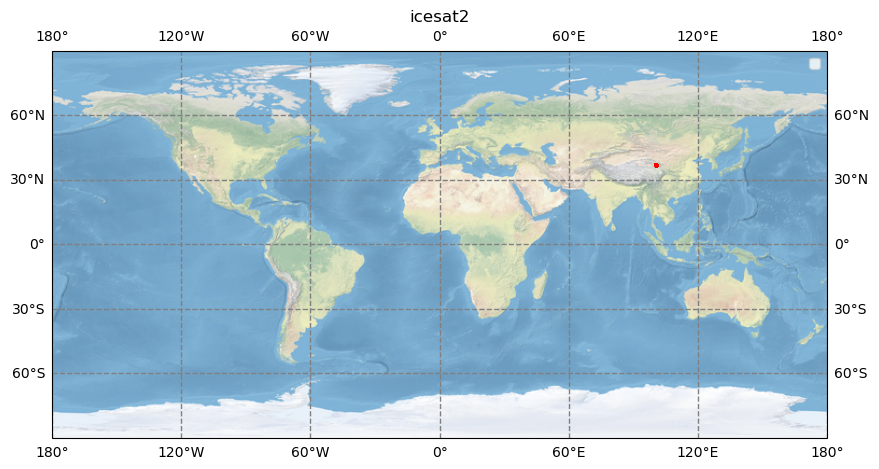

In [15]:
proj = ccrs.PlateCarree(central_longitude=0.0)
fig = plt.figure(figsize=(10, 10))
# orbit_isat = 'cycle_'+str(cycle)+'-track_'+str(track)
ax3 = fig.add_subplot(111, projection=proj); 
ax3.stock_img()
ax3.set_xlim(left=-180,right=180)
ax3.set_ylim(bottom=-90,top=90)
ax3.plot(lon,lat,marker='.',markersize=1,linewidth=0.0,color='red')
ax3.gridlines(draw_labels=True,linewidth=1,color='gray',linestyle='--')
ax3.legend()
plt.title('icesat2')

In [16]:
# ids_range=np.where((lat>24.70)&(lat<24.95)&(lon>102.60)&(lon<102.75)&(elev<5000))
# fig,ax=plt.subplots(1,2,figsize=(10,4))
# imgShow(rsimg.array,extent=rsimg.geoextent,clip_percent=5,ax=ax[0])
# ax[0].scatter(lon[ids_range],lat[ids_range],s=1.5,color='red')
# ax[1].plot(time[ids_range],elev[ids_range],'r.')
# elev[ids_range].mean() 
# vec.plot(ax=ax[0],facecolor="none",edgecolor="red")



<Axes: >

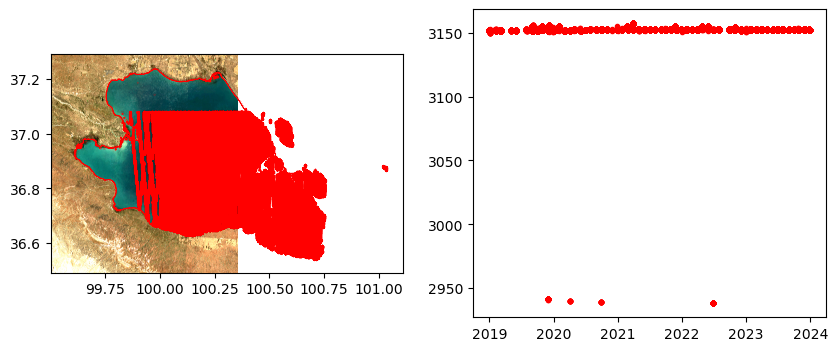

In [17]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
imgShow(rsimg.array,extent=rsimg.geoextent,clip_percent=5,ax=ax[0])
ax[0].scatter(lon,lat,s=1.5,color='red')
ax[1].plot(time,elev,'r.')
elev.mean() 
vec.plot(ax=ax[0],facecolor="none",edgecolor="red")

In [18]:
# ###筛选范围内激光点
# ids_range=np.zeros(shape=(lon.shape))
# for i,lon_value in enumerate(lon):
#   point =Point(lon_value,lat[i])
#   if vec.geometry[0].contains(point):
#     ids_range[i]=1
# ids_range[0:100]

In [19]:
# 读取其中的第一个图层或指定图层
vec=gpd.read_file(path_vec)
# 假设我们使用第一个几何对象来定义范围
boundary = vec.geometry[0]


# 假设 vec.geometry[0] 是一个多边形
# vec.geometry[0] = ...

# 创建一个用于存储结果的数组
ids_range = np.zeros(shape=(lon.shape))
# 定义处理函数
def process_points(lon_values, lat_values, start_idx, end_idx):
    for i in range(start_idx, end_idx):
        point = Point(lon_values[i], lat_values[i])
        if vec.geometry[0].contains(point):
            ids_range[i] = 1

# 将数据分成多个组
def split_data(data, num_groups):
    group_size = len(data) // num_groups
    return [(i * group_size, (i + 1) * group_size) for i in range(num_groups)]

# 设置线程数
num_threads = 3  # 根据需要调整线程数
data_groups = split_data(lon, num_threads)

# 使用线程池并行处理数据
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = []
    for start_idx, end_idx in data_groups:
        futures.append(executor.submit(process_points, lon, lat, start_idx, end_idx))

    # 等待所有线程完成
    for future in futures:
        future.result()

print("处理完成,ids_range:", ids_range)

处理完成,ids_range: [0. 0. 0. ... 1. 1. 1.]


In [20]:
#确保 ids_range 是布尔数组
ids_range = ids_range.astype(bool)
elev_range=elev[ids_range==1]
lon_range=lon[ids_range==1]
lat_range=lat[ids_range==1]
time_range=time[ids_range==1]
qf_bckgrd_range=qf_bckgrd[ids_range==1]
qf_bias_em_range=qf_bias_em[ids_range==1]
qf_bias_fit_range=qf_bias_fit[ids_range==1]
stdev_water_surf_range=stdev_water_surf[ids_range==1]

In [21]:
# # 创建 DataFrame
# df = pd.DataFrame({
#     "time": time_range,
#     "elev": elev_range,
#     "lat":lat_range,
#     "lon":lon_range
# })
# # print(df)
# ##过滤数据,保留10%-90%
# df_sorted=df.sort_values("elev")
# lower_bound=df_sorted["elev"].quantile(0.10)
# upper_bound=df_sorted["elev"].quantile(0.90)
# df_filtered=df_sorted[(df_sorted["elev"]>lower_bound)&(df_sorted["elev"]<upper_bound)]
# df_filtered.to_csv(r'E:\lakes\Qinghailake\readout\data.csv', index=False)
# print(df_filtered)

In [36]:
# 假设 time_range 等变量已经定义，构建 DataFrame
df = pd.DataFrame({
    "time": time_range,
    "elev": elev_range,
    "lat": lat_range,
    "lon": lon_range,
    "qf_bckgrd": qf_bckgrd_range,
    "qf_bias_em": qf_bias_em_range,
    "qf_bias_fit": qf_bias_fit_range,
    "stdev_water_surf": stdev_water_surf_range,
})

# 添加过滤条件
df_filtered = df[
    (~df['qf_bckgrd'].isin([6, 127])) &  # 删除 qf_bckgrd = 6 和 127 的数据
    (~df["qf_bias_em"].isin([-3, 3])) &  # 删除 qf_bias_em = -3 和 3 的数据
    (~df["qf_bias_fit"].isin([-3, 3])) &  # 删除 qf_bias_fit = -3 和 3 的数据
    (df["stdev_water_surf"] <= 2)  # 删除 stdev_water_surf > 2 的数据
]

# 输出过滤后的数据，返回 df_filtered
# print("Filtered data:")
# print(df_filtered)  # 输出过滤后的 DataFrame

# 打印过滤后的 DataFrame 的行数
print("Number of rows in df_filtered:", len(df_filtered))

Number of rows in df_filtered: 703985


In [37]:
def iqr_mad_outliers_by_time(df, column, time_column='time'):
    """
    使用四分位间距法 (IQR) 和中位数绝对偏差法 (MAD) 按照相同的时间段对数据进行筛选。
    
    参数：
    - df: DataFrame,包含需要筛选的数据。
    - column: str,需进行筛选的列名。
    - time_column: str,时间列名,默认为 'time'。
    
    返回：
    - filtered_df: 筛选后的数据（同时满足 IQR 和 MAD 条件）。
    - outliers_df: 筛选出的离群值数据。
    """
    # 存储筛选后的数据和离群值
    filtered_rows = []
    outliers_rows = []
    
    # 按照 time 列分组
    for _, group in df.groupby(time_column):
        # **四分位间距法 (IQR)**：
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower_iqr = q1 - 1.5 * iqr
        upper_iqr = q3 + 1.5 * iqr

        # **中位数绝对偏差法 (MAD)**：
        median = group[column].median()
        mad = (group[column] - median).abs().median()
        mad_threshold = 3 * mad  # 通常选择 3 倍的 MAD 作为离群值判断标准
        lower_mad = median - mad_threshold
        upper_mad = median + mad_threshold

        # 筛选满足 IQR 和 MAD 条件的数据
        filtered_group = group[
            (group[column] >= max(lower_iqr, lower_mad)) & 
            (group[column] <= min(upper_iqr, upper_mad))
        ]
        
        # 筛选离群值
        outliers_group = group[
            (group[column] < max(lower_iqr, lower_mad)) | 
            (group[column] > min(upper_iqr, upper_mad))
        ]
        
        # 将筛选后的数据和离群值分别添加到列表中
        filtered_rows.append(filtered_group)
        outliers_rows.append(outliers_group)

    # 将结果合并为 DataFrame
    filtered_df = pd.concat(filtered_rows).sort_index()
    outliers_df = pd.concat(outliers_rows).sort_index()

    return filtered_df, outliers_df

In [38]:
# 应用函数进行筛选
filtered_data, outliers_data = iqr_mad_outliers_by_time(df_filtered, column='elev')

# 查看结果
print("Number of rows in filtered data:", len(filtered_data))  # 行数

print("Number of rows in Outliers data:", len(outliers_data))  # 行数

Number of rows in filtered data: 644405
Number of rows in Outliers data: 59580


In [39]:
def decimal_to_date(decimal_time):
    year=int(decimal_time)
    remainder=decimal_time-year
    days_in_year=remainder*365.25
    date = pd.Timestamp(year=year, month=1, day=1) + pd.Timedelta(days=days_in_year)
    return date

In [40]:
df["date"]=filtered_data["time"].apply(decimal_to_date)

In [41]:
#提取年、季度、月份信息
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.to_period('Q')

In [42]:
# 按年分组并计算平均值
year_avg = df.groupby('year')['elev'].mean().reset_index()
# 按季度分组并计算平均值
quarter_avg = df.groupby('quarter')['elev'].mean().reset_index()
# 按月分组并计算平均值
month_avg = df.groupby(['year', 'month'])['elev'].mean().reset_index()
print(month_avg)

      year  month         elev
0   2019.0    1.0  3151.637207
1   2019.0    2.0  3151.951416
2   2019.0    3.0  3151.433838
3   2019.0    5.0  3152.084473
4   2019.0    6.0  3151.536621
5   2019.0    7.0  3152.316162
6   2019.0    8.0  3152.246582
7   2019.0    9.0  3152.078857
8   2019.0   10.0  3152.000488
9   2019.0   11.0  3152.301270
10  2019.0   12.0  3151.839111
11  2020.0    1.0  3152.111816
12  2020.0    2.0  3152.522217
13  2020.0    3.0  3151.828125
14  2020.0    4.0  3152.146729
15  2020.0    5.0  3152.183838
16  2020.0    6.0  3151.927734
17  2020.0    7.0  3152.322510
18  2020.0    8.0  3152.230225
19  2020.0    9.0  3152.527832
20  2020.0   10.0  3152.378418
21  2020.0   11.0  3152.495605
22  2020.0   12.0  3152.230225
23  2021.0    1.0  3152.361816
24  2021.0    2.0  3153.016113
25  2021.0    3.0  3152.405029
26  2021.0    4.0  3152.993164
27  2021.0    5.0  3152.432861
28  2021.0    6.0  3152.293213
29  2021.0    7.0  3152.295166
30  2021.0    8.0  3152.741943
31  2021

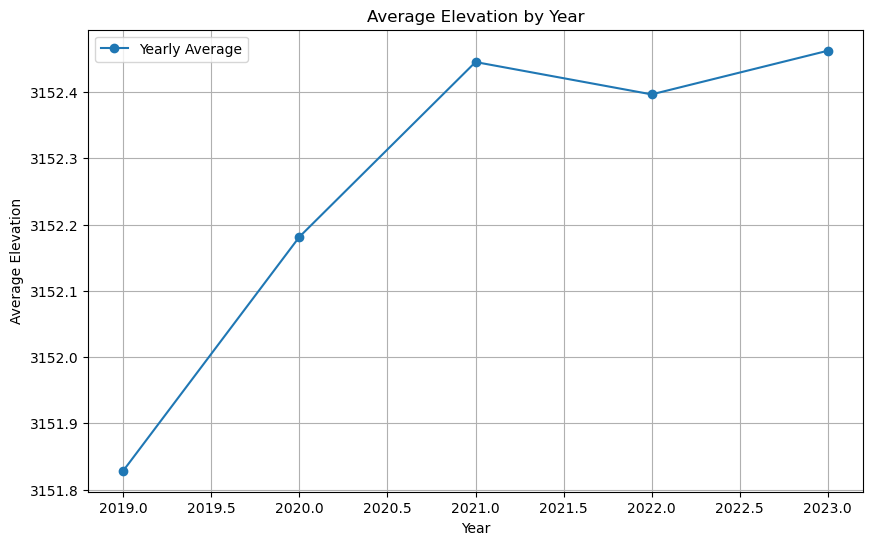

In [43]:
##年际变化
fig= plt.subplots(figsize=(10, 6))
plt.plot(year_avg["year"],year_avg["elev"],marker='o', label='Yearly Average')
plt.title('Average Elevation by Year')
plt.xlabel('Year')
plt.ylabel('Average Elevation')
plt.grid(True)
plt.legend()
plt.show()



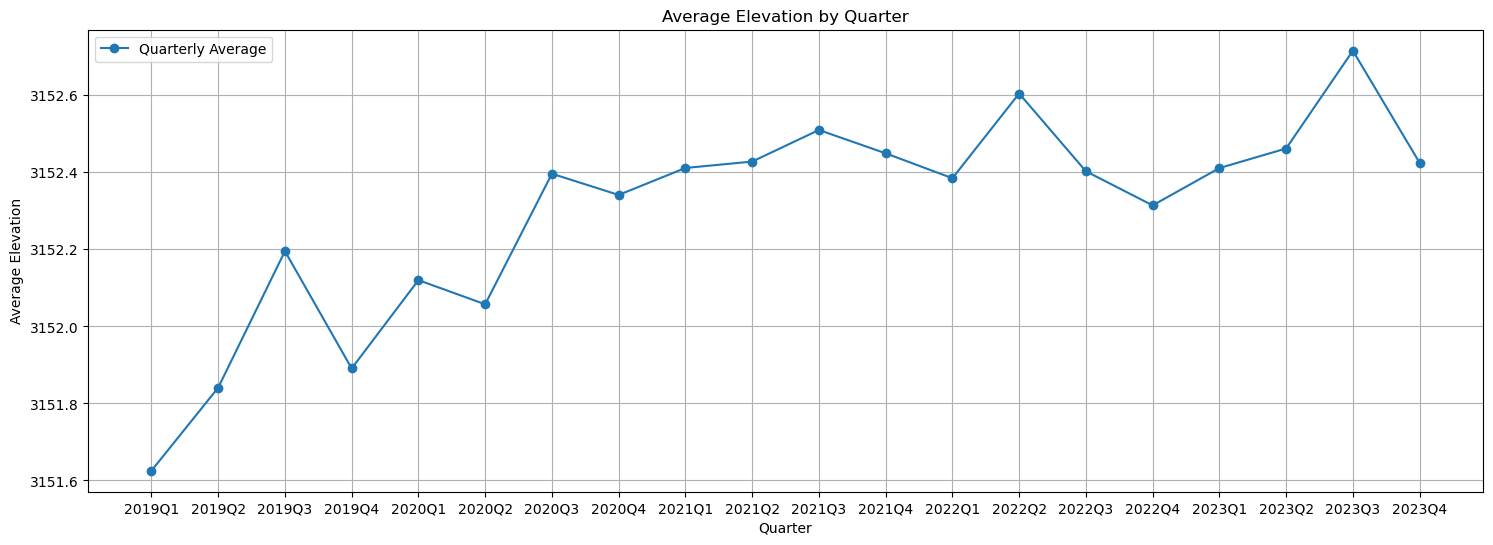

In [44]:
#季度变化
plt.figure(figsize=(18, 6))
plt.plot(quarter_avg['quarter'].astype(str), quarter_avg['elev'], marker='o', label='Quarterly Average')
plt.title('Average Elevation by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Elevation')
plt.grid(True)
plt.legend()
plt.show()


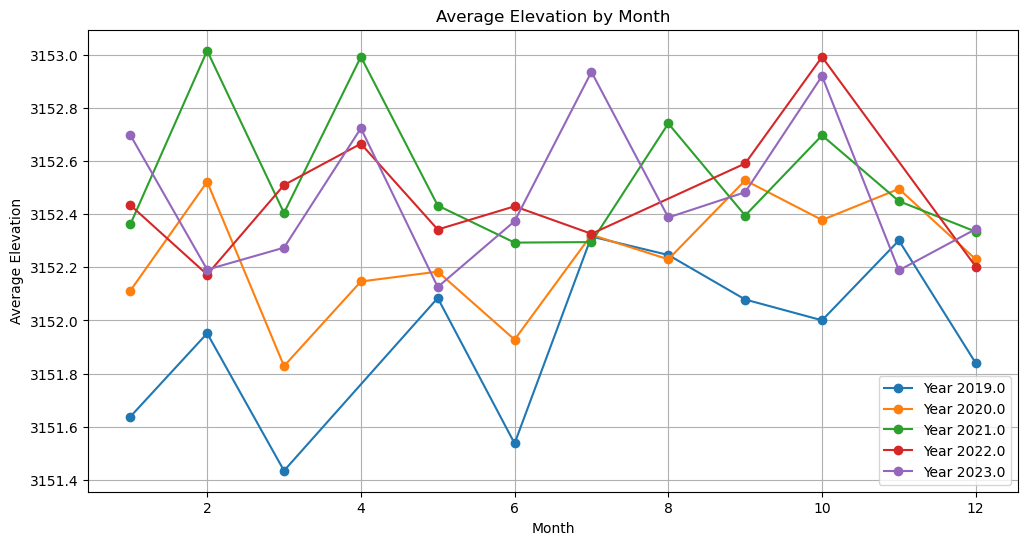

In [45]:
#月度变化
plt.figure(figsize=(12, 6))
for year in month_avg['year'].unique():
    year_data = month_avg[month_avg['year'] == year]
    plt.plot(year_data['month'], year_data['elev'], marker='o', label=f'Year {year}')

plt.title('Average Elevation by Month')
plt.xlabel('Month')
plt.ylabel('Average Elevation')
plt.grid(True)
plt.legend()
plt.show()